In [ ]:
# %matplotlib inline

# import pandas as pd
# import seaborn as sns
# from matplotlib import pyplot as plt
# from ase import units
# from pathlib import Path

# from mlip_arena.models import MLIPEnum


# color_mapping = {
#     'DAC': '#e41a1c',                    # e.g., red for DAC
#     'Flue Gas': '#377eb8', # e.g., blue
#     'General': '#4daf4a'              # e.g., green
# }

# for model in MLIPEnum:

#     fpath = Path(f"{model.name}.pkl")

#     if not fpath.exists():
#         continue

#     df = pd.read_pickle(fpath)
#     df.drop_duplicates(subset=['model', 'name', 'class'], keep='last')

#     df_exploded = df.explode(['henry_coefficient', 'averaged_interaction_energy', 'heat_of_adsorption'])
#     df_group = df_exploded.groupby(['model', 'name', 'class'])[['henry_coefficient', 'averaged_interaction_energy', 'heat_of_adsorption']]
#     df = df_group.mean()

#     print(model, len(df))

#     df['averaged_interaction_energy'] = df['averaged_interaction_energy'] * units._e  *  units._Nav * 1e-3 # Convert from eV to kJ/mol

#     fig, ax = plt.subplots(figsize=(3, 3))
#     sns.scatterplot(
#         data=df,
#         x="averaged_interaction_energy",
#         y="heat_of_adsorption",
#         hue="class",
#         palette=color_mapping,
#         ax=ax,
#     )

#     ax.set(
#         title=model.name,
#         # xlim=(-100, 0),
#         # ylim=(-100, 0),
#         xlabel='Averaged Interaction Energy (kJ/mol)',
#         ylabel='Heat of Adsorption (kJ/mol)',
#         aspect='equal'
#     )

#     # Add horizontal dashed decision boundaries
#     ax.axhline(y=-50, linestyle='--', color='gray', label='Exp. CO₂ Qst = 50 kJ/mol')
#     ax.axhline(y=-35, linestyle='--', color='gray', label='Exp. CO₂ Qst = 35 kJ/mol')

#     ax.legend(
#         # title='Class',
#         loc='upper left',
#         bbox_to_anchor=(1, 1),
#         frameon=False,
#     )
#     plt.show()


In [ ]:
from pathlib import Path

import pandas as pd
import plotly.colors as pcolors
import seaborn as sns
from matplotlib import pyplot as plt

from mlip_arena.models import MLIPEnum

mlip_methods = [
    model.name
    for model in MLIPEnum
]

all_attributes = dir(pcolors.qualitative)
color_palettes = {
    attr: getattr(pcolors.qualitative, attr)
    for attr in all_attributes
    if isinstance(getattr(pcolors.qualitative, attr), list)
}
color_palettes.pop("__all__", None)

palette_names = list(color_palettes.keys())
palette_colors = list(color_palettes.values())
palette_name = "Plotly"
color_sequence = color_palettes[palette_name]  # type: ignore

method_color_mapping = {
    method: color_sequence[i % len(color_sequence)]
    for i, method in enumerate(mlip_methods)
}

/tmp/ipykernel_447045/3752450599.py:127: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(xmin, xmax)


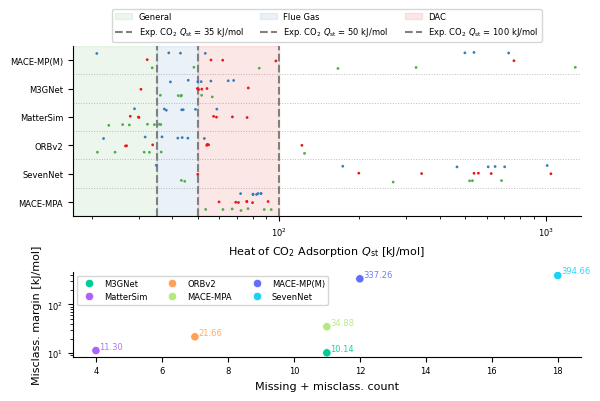

In [ ]:
%matplotlib inline

import numpy as np

from mlip_arena.models import MLIPEnum

# Color mapping by class
color_mapping = {
    "DAC": "#e41a1c",
    "Flue Gas": "#377eb8",
    "General": "#4daf4a"
}

# Decision boundary thresholds
thresholds = {
    "General": (None, 35),
    "Flue Gas": (35, 50),
    "DAC": (50, 100)
}

# Collect data from all models
all_data = []
margins = []

for model in MLIPEnum:
    fpath = Path(f"{model.name}.pkl")
    if not fpath.exists():
        continue

    df = pd.read_pickle(fpath)
    df = df.drop_duplicates(subset=["model", "name", "class"], keep="last")
    df_exploded = df.explode(["henry_coefficient", "averaged_interaction_energy", "heat_of_adsorption"])
    df_group = df_exploded.groupby(["model", "name", "class"])[["henry_coefficient", "averaged_interaction_energy", "heat_of_adsorption"]].mean().reset_index()

    df_group["model_name"] = model.name
    df_group["neg_heat"] = -df_group["heat_of_adsorption"]  # negate for log scale
    df_group = df_group[df_group["neg_heat"] > 0]  # remove invalid values

    df_group = df_group[df_group["name"] != "MIL-96-Al"]

    all_data.append(df_group)

    # Compute misclassification margin
    def point_misclassified(row):
        val = row["neg_heat"]
        lower, upper = thresholds[row["class"]]
        return (lower is not None and val < lower) or (upper is not None and val >= upper)

    misclassified = df_group[df_group.apply(point_misclassified, axis=1)]

    def distance_to_boundary(row):
        val = row["neg_heat"]
        lower, upper = thresholds[row["class"]]
        distances = []
        if lower is not None:
            distances.append(abs(val - lower))
        if upper is not None:
            distances.append(abs(val - upper))
        return min(distances)

    if not misclassified.empty:
        num_misclassified = len(misclassified) + (18 - len(df_group))
        margin = misclassified.apply(distance_to_boundary, axis=1).mean()
    else:
        num_misclassified = 0
        margin = 0.0

    margins.append((model.name, margin, num_misclassified))


# Combine all into one DataFrame
combined_df = pd.concat(all_data, ignore_index=True)
margins_df = pd.DataFrame(margins, columns=["model_name", "misclassification_margin", "num_misclassified"])

# --- Plotting ---

with plt.style.context("default"):

    LARGE_SIZE = 10
    MEDIUM_SIZE = 8
    SMALL_SIZE = 6

    plt.rcParams.update({
        "font.size": SMALL_SIZE,
        "axes.titlesize": MEDIUM_SIZE,
        "axes.labelsize": MEDIUM_SIZE,
        "xtick.labelsize": SMALL_SIZE,
        "ytick.labelsize": SMALL_SIZE,
        "legend.fontsize": SMALL_SIZE,
        "figure.titlesize": LARGE_SIZE,
    })

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=False, gridspec_kw={"height_ratios": [3, 1.5]})

    # --- Main Stripplot ---
    sns.stripplot(
        data=combined_df,
        x="neg_heat",
        y="model_name",
        hue="class",
        size=2,
        palette=color_mapping,
        dodge=True,
        jitter=0.1,
        alpha=1,
        ax=ax1,
    )

    xmin, xmax = ax1.get_xlim()

    ax1.axvspan(xmin, 35, color=color_mapping["General"], alpha=0.1, label="General")
    ax1.axvspan(35, 50, color=color_mapping["Flue Gas"], alpha=0.1, label="Flue Gas")
    ax1.axvspan(50, 100, color=color_mapping["DAC"], alpha=0.1, label="DAC")

    ax1.axvline(x=35, linestyle="--", color="gray", label="Exp. $\\mathregular{CO_2}$ $Q_\\text{st}$ = 35 kJ/mol")
    ax1.axvline(x=50, linestyle="--", color="gray", label="Exp. $\\mathregular{CO_2}$ $Q_\\text{st}$ = 50 kJ/mol")
    ax1.axvline(x=100, linestyle="--", color="gray", label="Exp. $\\mathregular{CO_2}$ $Q_\\text{st}$ = 100 kJ/mol")

    ax1.set_xscale("log")
    ax1.set_xlabel("Heat of $\\mathregular{CO_2}$ Adsorption $Q_\\text{st}$ [kJ/mol]")
    ax1.set_ylabel("")
    ax1.set_xlim(xmin, xmax)

    yticks = ax1.get_yticks()
    yticks = np.array(yticks)
    yticks = yticks[np.isfinite(yticks)]  # Remove any NaNs

    # Draw horizontal lines between models (skip the last one)
    for y in yticks[:-1] + np.diff(yticks) / 2:
        ax1.axhline(y=y, color="gray", linestyle=":", linewidth=0.7, alpha=0.5, zorder=0)

    handles, labels = ax1.get_legend_handles_labels()
    legend_dict = dict(zip(labels, handles, strict=False))

    desired_order = [
        "General", "Exp. $\\mathregular{CO_2}$ $Q_\\text{st}$ = 35 kJ/mol", "Flue Gas",
        "Exp. $\\mathregular{CO_2}$ $Q_\\text{st}$ = 50 kJ/mol", "DAC", "Exp. $\\mathregular{CO_2}$ $Q_\\text{st}$ = 100 kJ/mol"
    ]

    ordered_handles = [legend_dict[label] for label in desired_order if label in legend_dict]

    ax1.legend(
        ordered_handles,
        desired_order,
        loc="lower center",
        bbox_to_anchor=(0.5, 1),
        ncol=3,
        frameon=True
    )


    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)

    # --- Misclassification Margin Barplot ---

    # Sort by error margin
    margins_df_sorted = margins_df.sort_values(by="misclassification_margin", ascending=True)

    # Extract color values in order
    bar_colors = [method_color_mapping[m] for m in margins_df_sorted["model_name"]]

    sns.scatterplot(
        data=margins_df_sorted,
        x="num_misclassified",
        y="misclassification_margin",
        hue="model_name",
        palette=bar_colors,
        ax=ax2
    )

    for _, row in margins_df_sorted.iterrows():
        x = row["num_misclassified"]
        y = row["misclassification_margin"]
        model = row["model_name"]
        color = bar_colors[margins_df_sorted["model_name"].tolist().index(model)]

        ax2.text(
            x+0.1,
            y,
            f"{y:.2f}",
            fontsize=SMALL_SIZE,
            ha="left",
            va="bottom",
            color=color,
            alpha=0.9
        )

    ax2.set_ylabel("Misclass. margin [kJ/mol]")
    ax2.set_xlabel("Missing + misclass. count")
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    # ax2.set_xticklabels(margins_df_sorted["model_name"], rotation=45)
    ax2.set_yscale("log")

    handles, labels = ax2.get_legend_handles_labels()
    legend_dict = dict(zip(labels, handles, strict=False))
    ax2.legend(
        legend_dict.values(),
        legend_dict.keys(),
        loc="upper left",
        bbox_to_anchor=(0, 1),
        ncol=3,
        frameon=True
    )

    plt.tight_layout()
    plt.savefig("mof-misclassification_margin.pdf", bbox_inches="tight")
    plt.show()
